# Import google colab packages for accessing the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import other python packages as necessary

In [2]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import h5py
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Now List the contents of the drive and see the complete path of the data file to read

In [3]:
# List the contents of the drive
listed = drive.ListFile().GetList()
#for file in listed:
  #print('title {}, id {}'.format(file['title'], file['id']))

# Open the file as readonly
trainImages = np.load('/content/drive/MyDrive/data/covid-19-dataset/trainimage.npy')
trainLabels = pd.read_csv('/content/drive/MyDrive/data/covid-19-dataset/trainLabels.csv')

print(trainImages.shape)
print(trainLabels.shape)

(251, 128, 128, 3)
(251, 1)


## As shown above, there are 251 images which are 128x128 size and there are 3 channels

# Let's show some images

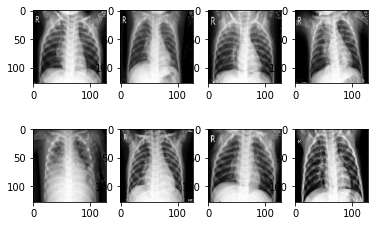

In [4]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImages[i])

# Let's check the data balance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

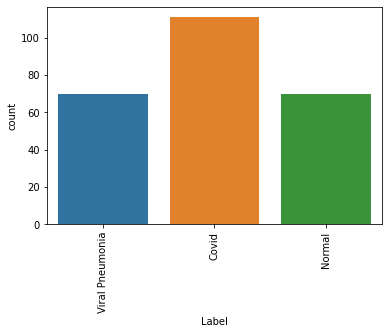

In [5]:
sns.countplot(trainLabels['Label'])
plt.xticks(rotation='vertical')

#### As shown above, data is quite balanced but covid patients seem to be more in number 

# Exploratory Data Analysis

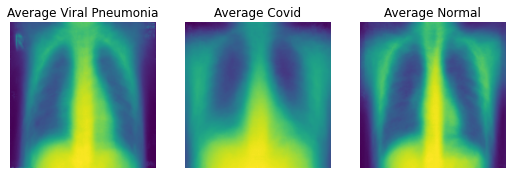

In [6]:
def find_mean_img(full_mat):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((150,150))
  
    return mean_img

CATEGORIES=trainLabels['Label'].unique()
d={ i:[] for i in CATEGORIES}

for i in trainLabels.index:
  gray = cv2.cvtColor(trainImages[i], cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray,(150,150))
  d[trainLabels['Label'][i]].append(gray)

l=[]
for i in d.keys():
  l.append(find_mean_img(d[i]))

plt.subplots(figsize=(12,12))
for i in range(len(l)):
    plt.subplot(3,4,i + 1,title='Average '+list(d.keys())[i])
    plt.imshow(l[i])
    plt.axis('off')

#### From the above picture, we can see that on an average a covid patient has a much weeker depiction of his/her lungs (due to infection) in the images compared to the other two categories - normal category is much better viewable

# Data Preprocessing 

#### Let's do the following as part of Image Preprocessing
* Convert the images to HSV (Better colors)
* Use Gaussian Blurring to reduce the noise
* Visualize the data after pre-processing

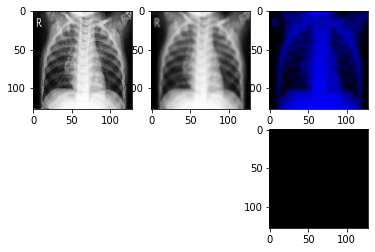

# CLEANED IMAGES


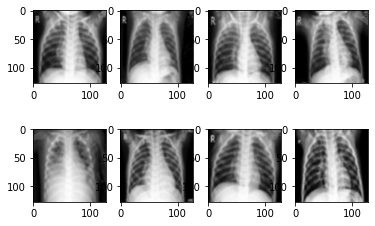

In [7]:
new_train = []
sets = []; getEx = True
for i in trainImages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) #Using BGR TO HSV conversion. reason is mentioned above
    #HSV Bou daries for the Green color (GREEN PARAMETERS)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper) # create a mask 
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(blurr)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)
print("# CLEANED IMAGES")
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

#### As shown above, its better to take the gaussian blurred images as the final processed images compared to HSV / Mask removed as they seem to be more darker 

# Normalization

In [8]:
# Normalize image data.
new_train = new_train / 255

# Convert the Labels 

In [9]:
# Convert labels from digits to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(trainLabels)

In [10]:
print(y.shape)
print(new_train.shape)

(251, 3)
(251, 128, 128, 3)


# Split the dataset

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_train,y , test_size=0.1, random_state=7,stratify=y)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(225, 128, 128, 3)
(225, 3)
(26, 128, 128, 3)
(26, 3)


# Check the class proportion as we have used stratify to have an equal distribution of the dataset

In [13]:
pd.DataFrame(y_train.argmax(axis=1)).value_counts()/pd.DataFrame(y_train.argmax(axis=1)).value_counts().sum()

0    0.44
1    0.28
2    0.28
dtype: float64

In [14]:
pd.DataFrame(y_test.argmax(axis=1)).value_counts()/pd.DataFrame(y_test.argmax(axis=1)).value_counts().sum()

0    0.461538
1    0.269231
2    0.269231
dtype: float64

# Build the CNN

In [15]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Set the CNN model 
batch_size=None


model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,128, 128, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [16]:
#Defining the optimizer and loss function 
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
# fitting the model with epochs = 50 
history = model.fit(X_train, y_train, epochs = 50, validation_split=0.1,batch_size = batch_size)

Epoch 1/50
7/7 [==============================] - 9s 429ms/step - loss: 1.1325 - accuracy: 0.3614 - val_loss: 1.0994 - val_accuracy: 0.3913
Epoch 2/50
7/7 [==============================] - 1s 113ms/step - loss: 1.0890 - accuracy: 0.4455 - val_loss: 1.1011 - val_accuracy: 0.3913
Epoch 3/50
7/7 [==============================] - 1s 113ms/step - loss: 1.0883 - accuracy: 0.4455 - val_loss: 1.1043 - val_accuracy: 0.3913
Epoch 4/50
7/7 [==============================] - 1s 112ms/step - loss: 1.0904 - accuracy: 0.4455 - val_loss: 1.0996 - val_accuracy: 0.3913
Epoch 5/50
7/7 [==============================] - 1s 112ms/step - loss: 1.0845 - accuracy: 0.4455 - val_loss: 1.0880 - val_accuracy: 0.3913
Epoch 6/50
7/7 [==============================] - 1s 117ms/step - loss: 0.9682 - accuracy: 0.4455 - val_loss: 1.0939 - val_accuracy: 0.2174
Epoch 7/50
7/7 [==============================] - 1s 112ms/step - loss: 0.9937 - accuracy: 0.4851 - val_loss: 0.8865 - val_accuracy: 0.5217
Epoch 8/50
7/7 [====

# Plotting the training and validation accuracy

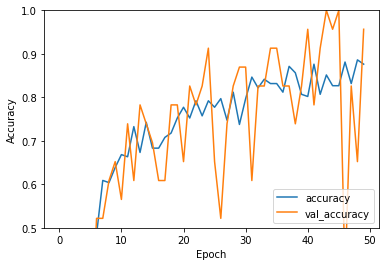

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

# Evaluate the Model

In [19]:
# Evaluate the model.
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 39)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36601483821868896
Test accuracy: 0.8846153616905212


#### As we see from the model, its learning well and also fits properly - the accuracy score also looks good 

# Divide the training data in training and validation set from X_train

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.1, random_state=7,stratify=y_train)

In [21]:
X_train.shape

(202, 128, 128, 3)

# Define the new model

In [22]:
# Set the CNN model 
batch_size=None
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,128, 128, 3)))


model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.2))


model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.4))



model1.add(GlobalMaxPooling2D())
model1.add(Dense(128, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation = "softmax"))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [23]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 50
batch_size = None

In [24]:
#Defining the optimizer and loss function 
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [25]:
X_train.shape[0]

202

In [26]:
#Fitting the model using fit_generator function 
#X_train, X_val, y_train, y_test
batch_size = 50
#stepsPerEpoch=X_train.shape[0]//batch_size
#history = model.fit(X_train, y_train, epochs = 50, validation_split=0.1,batch_size = batch_size)
history1 = model1.fit(X_train,y_train, epochs = 50, validation_data = (X_val,y_val), batch_size = batch_size, verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/50
5/5 - 5s - loss: 1.1128 - accuracy: 0.3911 - val_loss: 1.1004 - val_accuracy: 0.4348 - lr: 0.0010 - 5s/epoch - 1s/step
Epoch 2/50
5/5 - 1s - loss: 1.2077 - accuracy: 0.4109 - val_loss: 1.0902 - val_accuracy: 0.4348 - lr: 0.0010 - 750ms/epoch - 150ms/step
Epoch 3/50
5/5 - 1s - loss: 1.0807 - accuracy: 0.4406 - val_loss: 1.0855 - val_accuracy: 0.4348 - lr: 0.0010 - 759ms/epoch - 152ms/step
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 - 1s - loss: 1.1159 - accuracy: 0.4356 - val_loss: 1.0886 - val_accuracy: 0.4348 - lr: 0.0010 - 758ms/epoch - 152ms/step
Epoch 5/50
5/5 - 1s - loss: 1.0833 - accuracy: 0.4307 - val_loss: 1.0810 - val_accuracy: 0.4348 - lr: 5.0000e-04 - 781ms/epoch - 156ms/step
Epoch 6/50
5/5 - 1s - loss: 1.0356 - accuracy: 0.4406 - val_loss: 1.0807 - val_accuracy: 0.4348 - lr: 5.0000e-04 - 760ms/epoch - 152ms/step
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5/5 - 1s - loss: 

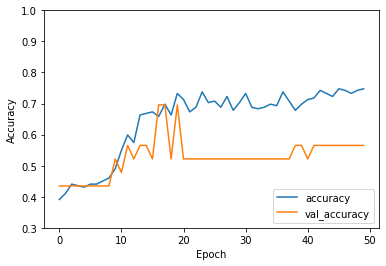

In [27]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right');

# Evaluate the new model

In [28]:
# Evaluate the model.

score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7629409432411194
Test accuracy: 0.692307710647583


# The accuracy has actually gone down with the changing learning rate - Let's use the first model

# Plot the confusion matrix for first model

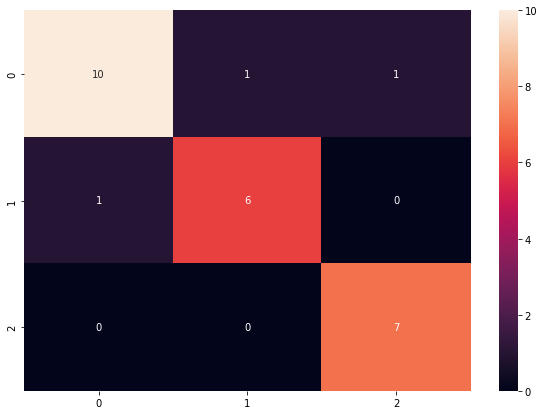

In [29]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 3)],
                  columns = [i for i in range(0, 3)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

# Plot the confusion matrix for tuned model

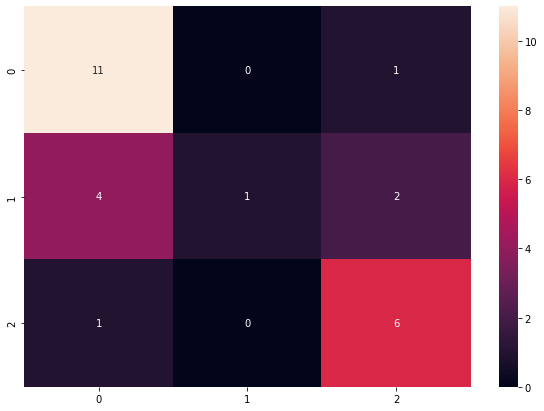

In [30]:
# Predict the values from the validation dataset
Y_pred = model1.predict(X_test)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 3)],
                  columns = [i for i in range(0, 3)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

# Visualize the Prediction with first model

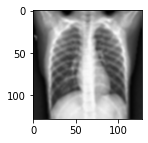

Predicted Label 1
True Label 1


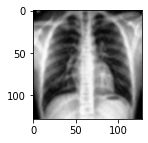

Predicted Label 0
True Label 1


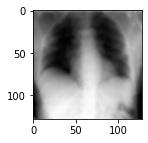

Predicted Label 0
True Label 0


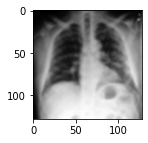

Predicted Label 2
True Label 0


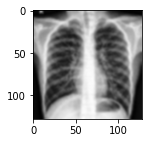

Predicted Label 1
True Label 1


In [31]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[16],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[16].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[16]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[20],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[20].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[20]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[25],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[25].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[25]))

# Visualize the Prediction with tuned model

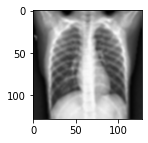

Predicted Label 2
True Label 1


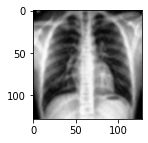

Predicted Label 0
True Label 1


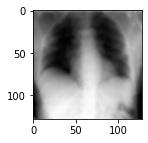

Predicted Label 0
True Label 0


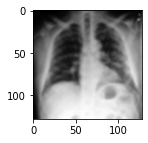

Predicted Label 0
True Label 0


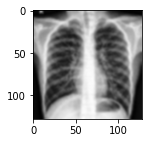

Predicted Label 0
True Label 1


In [32]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[16],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[16].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[16]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[20],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[20].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[20]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[25],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[25].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[25]))

# Observations
# As seen above, the first model seems to have performed better than the tuned model (with reducing learning rate) 